### Importing Lib's

In [2]:
import torch
from torch import nn
from pathlib import Path
from torch import nn
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt

### Creating Test and Train Data

In [3]:
dir_path = Path("data")
dir_path
train_dir = dir_path / "train"
test_dir = dir_path / "test"

random_images = list(dir_path.glob("*/*/*.jpg"))

### Opening any random image

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

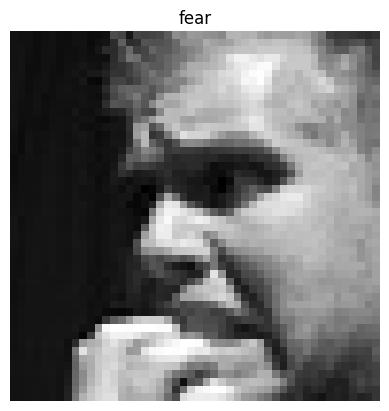

In [4]:
img = random.choice(random_images)
t = img.parent.stem
img = Image.open(img)
plt.imshow(img, cmap="gray")
plt.title(t)
plt.axis("off")

### Creating tranformer 

In [5]:
data_transform = transforms.Compose([
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

### Checking the transform on a single image


(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

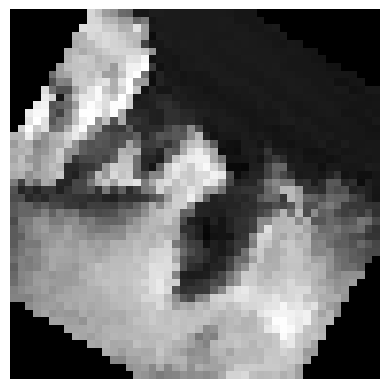

In [6]:
tran_img = data_transform(img)

plt.imshow(tran_img.permute(1,2,0),cmap="gray")
plt.axis("off")

### Creating datasets and dataloader

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=False,num_workers=8)

# train_dataloader,test_dataloader
# len(train_dataset),len(test_dataset)
train_dataset[0][0].shape,train_dataset.classes[train_dataset[0][1]]
classes = train_dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Creating model architect (TinyVGG)


In [8]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9*9,out_features=output_shape)
        )
    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(classes))

### creating training and testing loop

In [9]:
from tqdm.auto import tqdm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        acc = (y_pred.argmax(1) == y).sum().item()/len(y_pred)
        train_acc += acc
    return train_loss/len(dataloader),train_acc/len(dataloader)

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item()/len(y_pred)
            test_acc += acc
    return test_loss/len(dataloader),test_acc/len(dataloader)

def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    result = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss,train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss,test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")
    return result

result = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,epochs=5,device=device)


result

c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


 20%|██        | 1/5 [05:41<22:45, 341.33s/it]

Train loss: 1.81801 | Train acc: 0.25 | Test loss: 1.80905 | Test acc: 0.25
Epoch 2/5


 40%|████      | 2/5 [09:31<13:47, 275.82s/it]

Train loss: 1.80350 | Train acc: 0.25 | Test loss: 1.80330 | Test acc: 0.25
Epoch 3/5


 60%|██████    | 3/5 [13:21<08:29, 254.87s/it]

Train loss: 1.79603 | Train acc: 0.25 | Test loss: 1.79701 | Test acc: 0.25
Epoch 4/5


 80%|████████  | 4/5 [17:25<04:10, 250.83s/it]

Train loss: 1.78997 | Train acc: 0.25 | Test loss: 1.79063 | Test acc: 0.25
Epoch 5/5


100%|██████████| 5/5 [22:00<00:00, 264.03s/it]

Train loss: 1.78571 | Train acc: 0.25 | Test loss: 1.78140 | Test acc: 0.25


{'train_loss': [1.8180079207059427,
  1.8035018138657286,
  1.7960347426241188,
  1.7899689783417672,
  1.7857108272277573],
 'train_acc': [0.24922498171305166,
  0.2513149186666202,
  0.2522553902957261,
  0.24992162736424117,
  0.2527778745341182],
 'test_loss': [1.8090495838365637,
  1.8033011370164898,
  1.7970107000297277,
  1.7906288902352334,
  1.7814038428598606],
 'test_acc': [0.24714405126776262,
  0.24714405126776262,
  0.24658679297854555,
  0.24853719699080523,
  0.2520200612984118]}

## Plotting Loss Curve

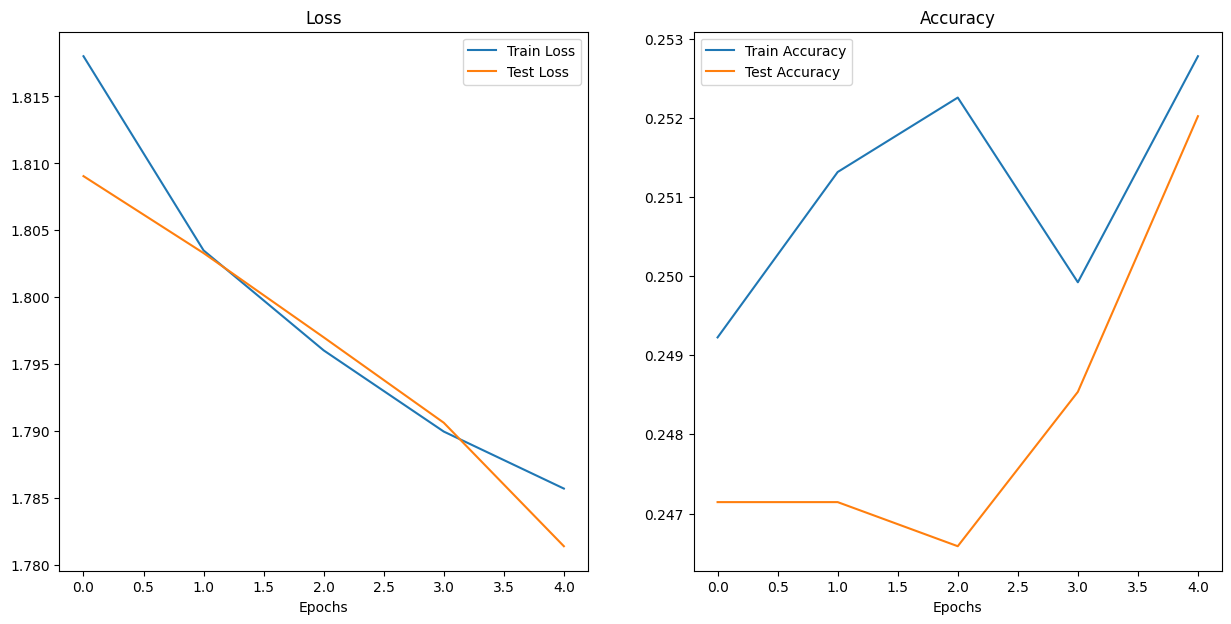

In [10]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    
    Args:
        results (dict): Dictionary containing lists of values, specifically:
            - train_loss
            - train_acc
            - test_loss
            - test_acc
    """
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(result)